In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import torch
import torch.nn as nn
from torch.autograd import Variable

from instructor import Instructor
from cvx_net import CvxNet


plt.style.use('bmh')

# Training

In [10]:
cuda = False

npzfile=np.load('double_integrator_0.1cost.npz') 
x0 = npzfile['x'] 
c_u = npzfile['cost_u'] 
print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)

shape of x0: (6561, 2)  |shape of [cost, u]: (6561, 6)


In [3]:
x = Variable(torch.from_numpy(x0).float(), requires_grad=False)
y = Variable((torch.from_numpy(c_u[:,:])).float(), requires_grad=False)
if cuda:
    x = x.cuda()
    y = y.cuda()
print("Example, x:", x[100], " |cost_u[0]:",y[100,:])

# split the dataset into train and test
dataset = torch.utils.data.TensorDataset(x,y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("train size:",len(train_dataset)," |test size:",len(test_dataset))

# shuffle the data, build dataset batches
batch_size = 80
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

Example, x: tensor([-3.9000, -2.1000])  |cost_u[0]: tensor([ 5.7462,  4.2991, -0.5921, -0.8609, -0.4649, -0.1762])
train size: 5248  |test size: 1313


In [4]:
# Initialize the model.

dim_inp = x0.shape[1]
dim_out = 1
model = CvxNet(dim_inp, dim_out,collect=False,cuda=cuda)
device = torch.device("cuda:0" if cuda else "cpu")
model = model.to(device)
loss_fun = torch.nn.MSELoss() # Initialize the loss function

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses_train = []
losses_test = []
instructor = Instructor(model, optimizer, loss_fun)
run_loss = 0.0


In [5]:
print('A',model.A)
print('B',model.B)
print('Q',model.Q.mm(model.Q.t()))
print('R',model.R.mm(model.R.t()))
print('s0',model.s0)
print('s1',model.s1)
print('s2',model.s2)

A Parameter containing:
tensor([[0.1796, 0.5547],
        [0.9301, 0.5259]], requires_grad=True)
B Parameter containing:
tensor([[0.6394],
        [0.5882]], requires_grad=True)
Q tensor([[0.2514, 0.2675],
        [0.2675, 0.4098]], grad_fn=<MmBackward>)
R tensor([[0.2018]], grad_fn=<MmBackward>)
s0 Parameter containing:
tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
s1 Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])
s2 Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


In [6]:
for epoch in range(50):
    loss_train, run_loss = instructor.train(train_loader,epoch,run_loss)
    loss_test = instructor.evaluate(test_loader)
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    print('[epoch: %d] training loss: %.3f, testing loss: %.3f' %
                      (epoch + 1, loss_train, loss_test))

[epoch: 1] training loss: 2.660, testing loss: 2.259
[epoch: 2] training loss: 1.694, testing loss: 1.260
[epoch: 3] training loss: 0.826, testing loss: 0.510
[epoch: 4] training loss: 0.297, testing loss: 0.164
[epoch: 5] training loss: 0.103, testing loss: 0.066
[epoch: 6] training loss: 0.049, testing loss: 0.042
[epoch: 7] training loss: 0.035, testing loss: 0.034
[epoch: 8] training loss: 0.029, testing loss: 0.031
[epoch: 9] training loss: 0.026, testing loss: 0.027
[epoch: 10] training loss: 0.023, testing loss: 0.024
[epoch: 11] training loss: 0.020, testing loss: 0.024
[epoch: 12] training loss: 0.018, testing loss: 0.020
[epoch: 13] training loss: 0.017, testing loss: 0.018
[epoch: 14] training loss: 0.015, testing loss: 0.017
[epoch: 15] training loss: 0.014, testing loss: 0.016
[epoch: 16] training loss: 0.013, testing loss: 0.015
[epoch: 17] training loss: 0.012, testing loss: 0.014
[epoch: 18] training loss: 0.011, testing loss: 0.014
[epoch: 19] training loss: 0.011, tes

In [7]:
print('A',model.A)
print('B',model.B)
print('Q',model.Q.mm(model.Q.t()))
print('R',model.R.mm(model.R.t()))
print('s0',model.s0)
print('s1',model.s1)
print('s2',model.s2)

A Parameter containing:
tensor([[-0.1492,  0.6984],
        [ 0.6934,  0.7124]], requires_grad=True)
B Parameter containing:
tensor([[0.4824],
        [0.2966]], requires_grad=True)
Q tensor([[1.1001, 0.9567],
        [0.9567, 0.8701]], grad_fn=<MmBackward>)
R tensor([[0.6184]], grad_fn=<MmBackward>)
s0 Parameter containing:
tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
s1 Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])
s2 Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


(0.0, 2.7924745795316994)

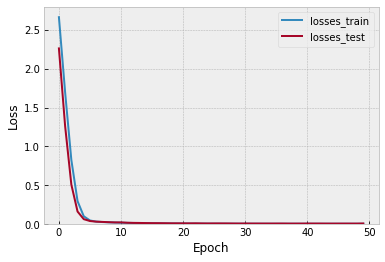

In [8]:
plt.plot(losses_train, label='losses_train')
plt.plot(losses_test, label='losses_test')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(ymin=0.)

In [9]:
model.eval()
with torch.no_grad():
    for n, (inp, out) in enumerate(test_loader):
        out_pre = model(inp[0,:].unsqueeze(0))
        print('input: ',inp[0,:])
        print('pre: ',out_pre)
        print('true: ',out[0,:])
        print('\n\n\n')


input:  tensor([3.3000, 1.3000])
pre:  tensor([[ 3.3029, -3.1255, -2.0460, -0.6765, -0.4352, -0.1191]])
true:  tensor([ 3.2986, -3.0979,  0.5319,  0.6858,  0.3635,  0.1365])




input:  tensor([ 1.5000, -1.7000])
pre:  tensor([[0.1603, 1.1815, 0.2161, 0.2656, 0.0433, 0.0555]])
true:  tensor([0.1594, 1.1847, 0.3898, 0.1065, 0.0216, 0.0015])




input:  tensor([-3.3000, -0.6000])
pre:  tensor([[2.2879, 2.3303, 1.6959, 0.5014, 0.3615, 0.0856]])
true:  tensor([ 2.2822,  2.3057, -0.5771, -0.6233, -0.3193, -0.1182])




input:  tensor([-3.1000, -1.3000])
pre:  tensor([[3.0347, 3.0255, 1.9615, 0.6552, 0.4171, 0.1157]])
true:  tensor([ 3.0311,  2.9993, -0.4945, -0.6513, -0.3465, -0.1303])




input:  tensor([-0.5000, -2.9000])
pre:  tensor([[2.3293, 3.5438, 1.6623, 0.7787, 0.3505, 0.1476]])
true:  tensor([ 2.3338,  3.5287,  0.0941, -0.3460, -0.2246, -0.0921])




input:  tensor([-3.8000, -2.1000])
pre:  tensor([[5.5722, 4.2840, 2.6577, 0.9299, 0.5646, 0.1660]])
true:  tensor([ 5.5684,  4.2498,

In [10]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

shape of x0: (6561, 2)  |shape of [cost, u]: (6561, 6)
Example, x: tensor([-4., -4.])  |cost_u[0]: tensor([11.9006,  8.0000, -2.5559, -1.0050, -0.3310, -0.0864])
pre:  torch.Size([6561, 6])


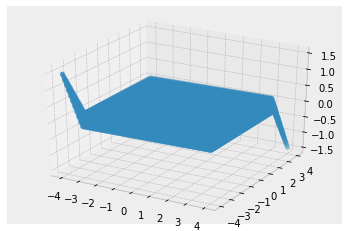

In [16]:
# get x0, u0 from dataset
print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)
X1 = x0[:,0]
X2 = x0[:,1]
U0 = c_u[:,1]

x = Variable(torch.from_numpy(x0).float(), requires_grad=False)
y = Variable((torch.from_numpy(c_u[:,:])).float(), requires_grad=False)
if cuda:
    x = x.cuda()
    y = y.cuda()
print("Example, x:", x[0], " |cost_u[0]:",y[0,:])
model.eval()
with torch.no_grad():
    out_pre = model(x)
    print('pre: ',out_pre.size())
U0_pre = out_pre[:,1].cpu().numpy()

# print u0-u0_pre
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, U0-U0_pre,cmap=cm.coolwarm)
# ax.scatter(X1, X2,U0_pre )


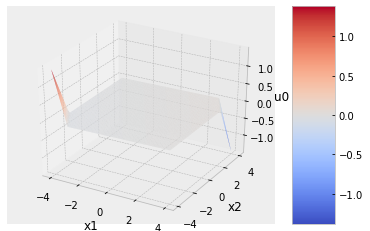

In [17]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X1, X2, U0-U0_pre,cmap=cm.coolwarm )
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')
# Customize the z axis.
#ax.set_zlim(-2, 2)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=1, aspect=5)

plt.show()

Text(0.5, 0, 'u0  ')

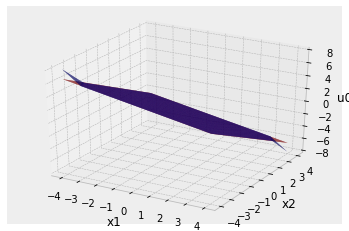

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X1, X2, U0,color="b")
ax.plot_trisurf(X1, X2, U0_pre,color="r" )
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')


# Collect MPC data by forward
Because MPC solutions by mpt and opt are different

In [43]:
# Initialize the model.
dim_inp = 2  # dimension of x
dim_out = 1  # dimension of u
num_u = 5  # N = num_u/dim_out
model = CvxNet(dim_inp, dim_out, num_u = 5, cuda=False, collect=True)
model.eval()
list_inp = []
list_out = []
u_max = 10.0
with torch.no_grad():
    for x1 in np.arange(-4.0,4.1,0.1):
        for x2 in np.arange(-4.0,4.1,0.1):
            inp = torch.tensor([x1,x2]).unsqueeze(0)
            out = model(inp)
#             if (out[0,1]<=u_max and out[0,1]>=-u_max and
#                 out[0,2]<=u_max and out[0,2]>=-u_max and
#                 out[0,3]<=u_max and out[0,3]>=-u_max and
#                 out[0,4]<=u_max and out[0,4]>=-u_max and
#                 out[0,5]<=u_max and out[0,5]>=-u_max):
            list_inp.append(inp.numpy())
            list_out.append(out.numpy())
#             print('input: ',inp[0,:])
#             print('pre: ',out)
#             print('\n')

In [44]:
inp_ = np.array(list_inp).squeeze()
out_ = np.array(list_out).squeeze()
np.savez('double_integrator_0.1cost.npz',x=inp_,cost_u=out_) 

In [26]:
a = Parameter(torch.rand(2, 2))
print(a)
b = a.t().mm(a)
c = sqrtm(b)
print(c)
print(c.t().mm(c))
print(b)


Parameter containing:
tensor([[0.7222, 0.9344],
        [0.8773, 0.6384]], requires_grad=True)
tensor([[0.9098, 0.6808],
        [0.6808, 0.9039]], grad_fn=<MatrixSquareRootBackward>)
tensor([[1.2912, 1.2348],
        [1.2348, 1.2806]], grad_fn=<MmBackward>)
tensor([[1.2912, 1.2348],
        [1.2348, 1.2806]], grad_fn=<MmBackward>)
